# Simple predictions

## Naive prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
np.random.seed(4312)

<Axes: title={'center': 'Random Walk Time Series'}>

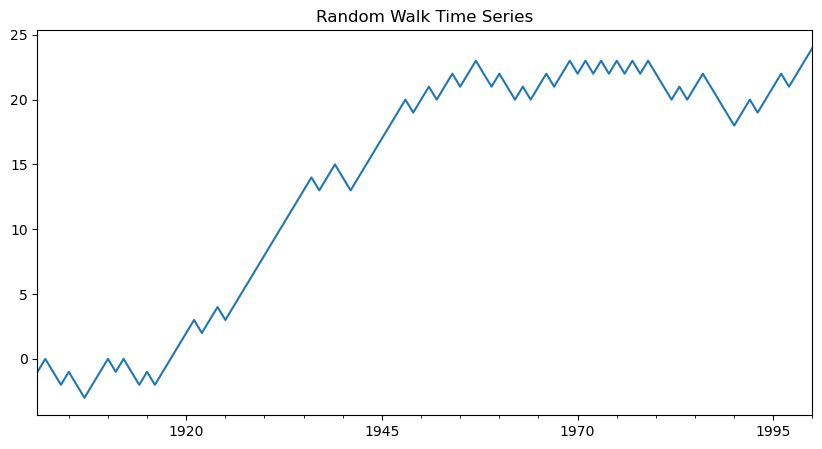

In [3]:
x = np.cumsum(np.random.choice([-1, 1], size = 100, replace = True))
series = pd.Series(x, index = pd.date_range(start = '1901', end = '2001', freq = 'YE'))
plt.figure(figsize = (10, 5))
series.plot(title = 'Random Walk Time Series')

In [4]:
model = SimpleExpSmoothing(series)
fit = model.fit(smoothing_level = 1, optimized = False)
prev = fit.forecast(5)
prev

2001-12-31    24.0
2002-12-31    24.0
2003-12-31    24.0
2004-12-31    24.0
2005-12-31    24.0
Freq: YE-DEC, dtype: float64

In [5]:
# Fit values and residuals
fitted_values = fit.fittedvalues
residuals = series - fitted_values

print(
f"""[fitted_values]: 
{fitted_values}

[residuals]: 
{residuals}
""")

[fitted_values]: 
1901-12-31    -1.0
1902-12-31    -1.0
1903-12-31     0.0
1904-12-31    -1.0
1905-12-31    -2.0
              ... 
1996-12-31    21.0
1997-12-31    22.0
1998-12-31    21.0
1999-12-31    22.0
2000-12-31    23.0
Freq: YE-DEC, Length: 100, dtype: float64

[residuals]: 
1901-12-31    0.0
1902-12-31    1.0
1903-12-31   -1.0
1904-12-31   -1.0
1905-12-31    1.0
             ... 
1996-12-31    1.0
1997-12-31   -1.0
1998-12-31    1.0
1999-12-31    1.0
2000-12-31    1.0
Freq: YE-DEC, Length: 100, dtype: float64



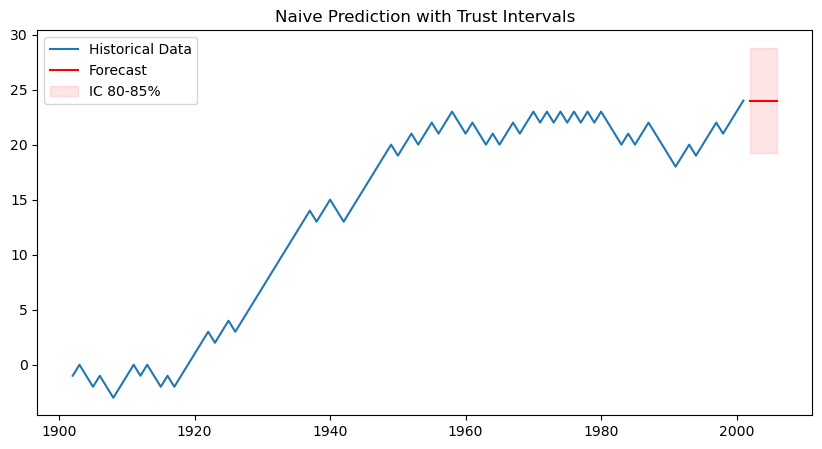

In [6]:
# Plor prediction with trust intervals
plt.figure(figsize = (10, 5))
plt.plot(series.index, series, label = 'Historical Data')
plt.plot(pd.date_range(start = '2001', periods = 5, freq = 'YE'), prev, label = 'Forecast', color = 'red')
plt.fill_between(pd.date_range(start = '2001', periods = 5, freq = 'YE'), prev * 0.8, prev * 1.2, color = 'red', alpha = 0.1, label = 'IC 80-85%')

plt.title('Naive Prediction with Trust Intervals')
plt.legend()

In [7]:
# Alterar o intervalo de confianca (é preciso usar outro metodo para ICs diferentes)
model_arima = ARIMA(series, order = (0,1,0)) # ARIMA(0,1,0) é equivalente a previsão Naive
fit_arima = model_arima.fit()
prev2 = fit_arima.get_forecast(steps = 5)
conf_int99 = prev2.conf_int(alpha = 0.01) # 99% IC
conf_int95 = prev2.conf_int(alpha = 0.05) # 95% IC

print(
f"""Previsao com diferentes ICs:
[Previsao pontual]: 
{prev2.predicted_mean}

[ICs Intervalos de Confianca (95% e 99%)]:
95%: {conf_int95}
99%: {conf_int99}
"""
)

Previsao com diferentes ICs:
[Previsao pontual]: 
2001-12-31    24.0
2002-12-31    24.0
2003-12-31    24.0
2004-12-31    24.0
2005-12-31    24.0
Freq: YE-DEC, Name: predicted_mean, dtype: float64

[ICs Intervalos de Confianca (95% e 99%)]:
95%:               lower y    upper y
2001-12-31  22.040047  25.959953
2002-12-31  21.228207  26.771793
2003-12-31  20.605261  27.394739
2004-12-31  20.080093  27.919907
2005-12-31  19.617411  28.382589
99%:               lower y    upper y
2001-12-31  21.424185  26.575815
2002-12-31  20.357247  27.642753
2003-12-31  19.538557  28.461443
2004-12-31  18.848369  29.151631
2005-12-31  18.240302  29.759698



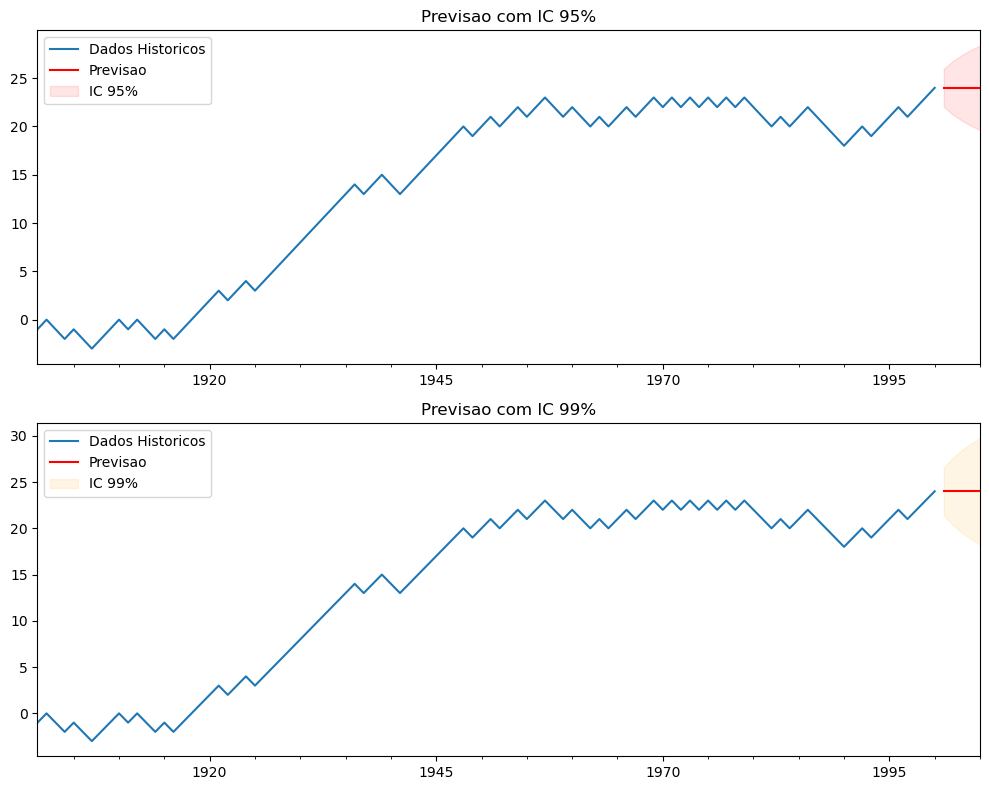

In [8]:
# Plotar comparacao
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 8))

# Plot 1 - Previsao original
series.plot(ax = ax1, label = 'Dados Historicos' )
prev2.predicted_mean.plot(ax = ax1, color = 'red', label = 'Previsao')
ax1.fill_between(prev2.predicted_mean.index, conf_int95.iloc[:, 0], conf_int95.iloc[:, 1], color = 'red', alpha = 0.1, label = 'IC 95%')
ax1.set_title('Previsao com IC 95%')
ax1.legend()

# Plot 2 - Previsao com multiplos ICs 
series.plot(ax = ax2, label = 'Dados Historicos')
prev2.predicted_mean.plot(ax = ax2, color = 'red', label = 'Previsao')
ax2.fill_between(prev2.predicted_mean.index, conf_int99.iloc[:, 0], conf_int99.iloc[:, 1], color = 'orange', alpha = 0.1, label = 'IC 99%')
ax2.set_title('Previsao com IC 99%') 
ax2.legend()

plt.tight_layout()

In [10]:
# Naive sazonal - usando AirPassengers
air_passengers = sm.datasets.get_rdataset('AirPassengers', 'datasets').data
air_passengers['time'] = pd.to_datetime(air_passengers['time'])
air_passengers.set_index('time', inplace = True)
air_series = air_passengers['value']

<Axes: title={'center': 'AirPassengers Time Series'}, xlabel='time'>

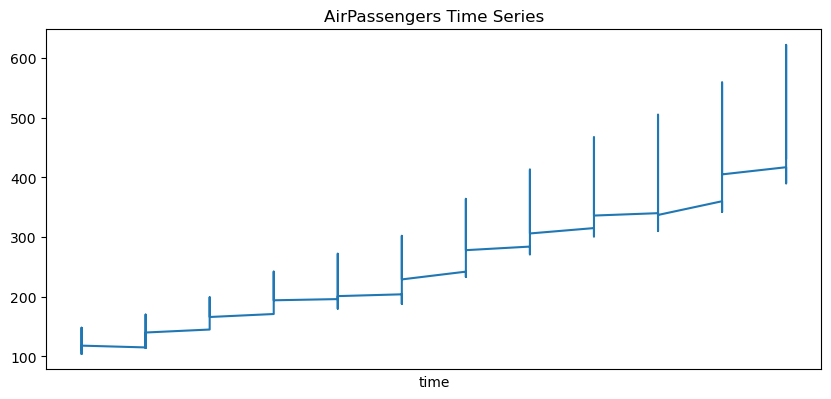

In [11]:
# Plotar serie AirPassengers
plt.figure(figsize = (10, 5))
air_series.plot(title = 'AirPassengers Time Series')

In [13]:
# Previsao sazonal naive (ultimo padrao sazonal repetido)
last_year = air_series[-12 : ] # Ultimo ano de dados
prev3 = pd.Series(np.tile(last_year.values, 1)[ : 12], # Repete o padrao
                  index = pd.date_range(start = air_series.index[-1] + pd.DateOffset(months = 1), periods = 12, freq = 'ME'))

print(
f"""
[Previsao Naive Sazonal]:

{prev3}
""")


[Previsao Naive Sazonal]:

1970-02-28 00:00:00.000001960    417
1970-03-31 00:00:00.000001960    391
1970-04-30 00:00:00.000001960    419
1970-05-31 00:00:00.000001960    461
1970-06-30 00:00:00.000001960    472
1970-07-31 00:00:00.000001960    535
1970-08-31 00:00:00.000001960    622
1970-09-30 00:00:00.000001960    606
1970-10-31 00:00:00.000001960    508
1970-11-30 00:00:00.000001960    461
1970-12-31 00:00:00.000001960    390
1971-01-31 00:00:00.000001960    432
Freq: ME, dtype: int64



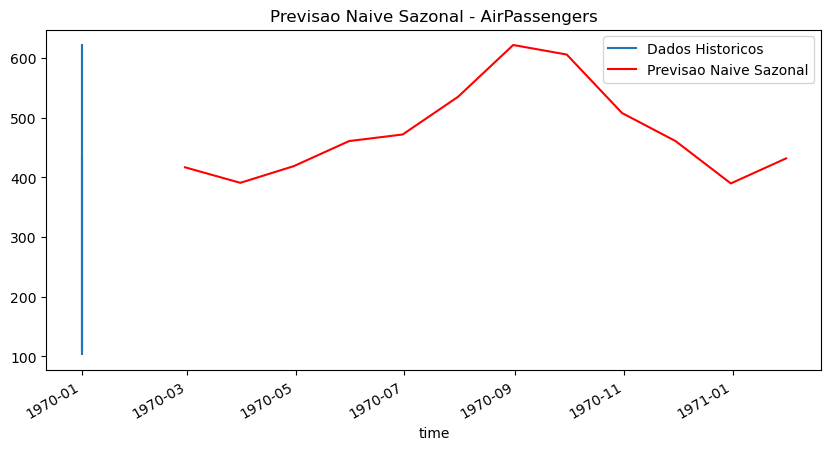

In [14]:
# Plotar previsão sazonal
plt.figure(figsize = (10, 5))
air_series.plot(label = 'Dados Historicos')
prev3.plot(label = 'Previsao Naive Sazonal', color = 'red')
plt.title('Previsao Naive Sazonal - AirPassengers')
plt.legend()

In [15]:
# Comparar com o ultimo ano
print(
f"""
[Ultimo ano de dados]:

{air_series}"""
)


[Ultimo ano de dados]:

time
1970-01-01 00:00:00.000001949    112
1970-01-01 00:00:00.000001949    118
1970-01-01 00:00:00.000001949    132
1970-01-01 00:00:00.000001949    129
1970-01-01 00:00:00.000001949    121
                                ... 
1970-01-01 00:00:00.000001960    606
1970-01-01 00:00:00.000001960    508
1970-01-01 00:00:00.000001960    461
1970-01-01 00:00:00.000001960    390
1970-01-01 00:00:00.000001960    432
Name: value, Length: 144, dtype: int64


## Meanf prediction

In [6]:
# Bibliotecas
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.statespace.tools import ctime

ImportError: cannot import name 'ctime' from 'statsmodels.tsa.statespace.tools' (/opt/homebrew/Caskroom/miniconda/base/envs/time-series/lib/python3.10/site-packages/statsmodels/tsa/statespace/tools.py)

In [3]:
# Carregar os dados fdeaths (dados mensais de mortes no Reino Unido 1974-1979)|

dates = pd.date_range(start='1974-01', end='1980-01', freq='ME')

fdeaths = [901, 689, 827, 677, 522, 406, 441, 393, 387, 582, 578, 666,  #1974
           830, 752, 785, 664, 467, 438, 421, 412, 343, 440, 531, 771,  #1975
           767, 1141, 896, 532, 447, 420, 376, 330, 357, 445, 546, 764, #1976
           862, 660, 663, 643, 502, 392, 411, 348, 387, 385, 411, 638,  #1977
           796, 853, 737, 546, 530, 446, 431, 362, 387, 430, 425, 679,  #1978
           821, 785, 727, 612, 478, 429, 405, 379, 393, 411, 487, 574]  #1979

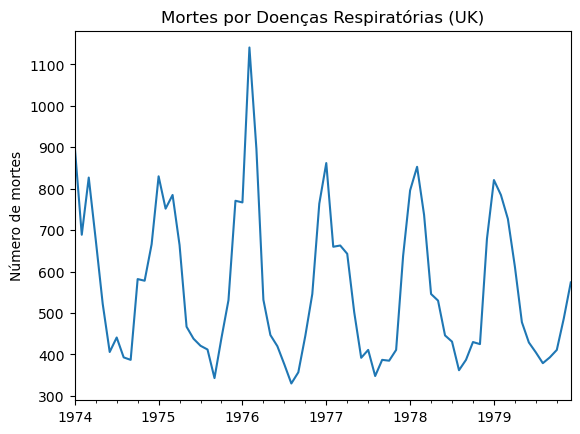

Média global: 560.6805555555555


In [7]:
# Criar série temporal
fdeaths_ts = pd.Series(fdeaths, index=dates)

# Plotar a série
fdeaths_ts.plot(title='Mortes por Doenças Respiratórias (UK)')
plt.ylabel('Número de mortes')
plt.show()

# Verificar a média
print("Média global:", fdeaths_ts.mean())

In [8]:
# Previsão com método meanf (média simples) 

def meanf(series, h):
    mean_val = series.mean()
    forecast = pd.Series([mean_val] * h,
                         index=pd.date_range(
                             start=series.index[-1] + pd.Timedelta(days=1),
                             periods=h,
                             freq='ME'))
    return forecast

prev = meanf(fdeaths_ts, h=5)
print("Previsão (média global): \n", prev)

Previsão (média global): 
 1980-01-31    560.680556
1980-02-29    560.680556
1980-03-31    560.680556
1980-04-30    560.680556
1980-05-31    560.680556
Freq: ME, dtype: float64


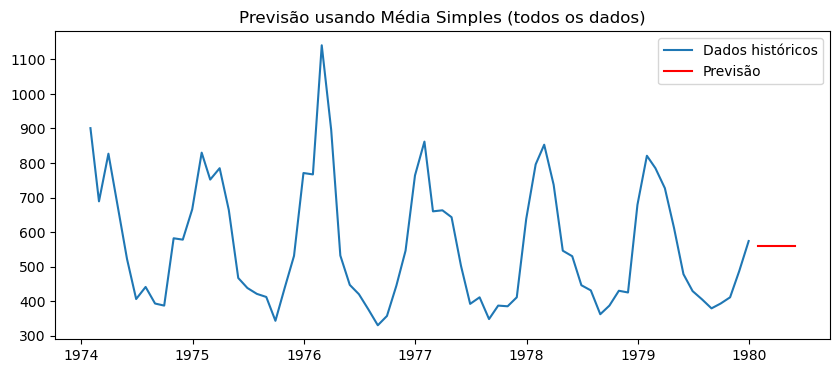

In [9]:
# Plotar previsão
plt.figure(figsize =(10,4))
plt.plot(fdeaths_ts, label='Dados históricos')
plt.plot(prev, label='Previsão', color='red')
plt.title('Previsão usando Média Simples (todos os dados)')
plt.legend()
plt.show()

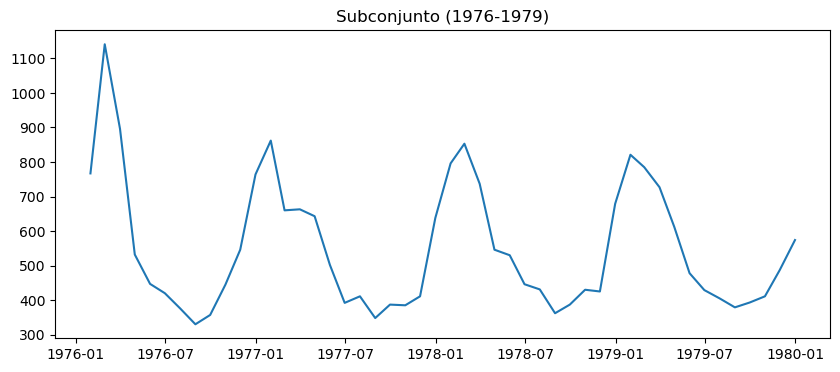

Média do subconjunto: 550.9583333333334


In [10]:
# Previsão com subconjunto (1976-1979)
fdeaths2_ts = fdeaths_ts['1976':'1979']
plt.figure(figsize=(10, 4))
plt.plot(fdeaths2_ts)
plt.title('Subconjunto (1976-1979)')
plt.show()
print("Média do subconjunto:", fdeaths2_ts.mean())

In [12]:
prev2 = meanf(fdeaths2_ts, h=5)
print("Previsão (subconjunto): \n'", prev2)

Previsão (subconjunto): 
' 1980-01-31    550.958333
1980-02-29    550.958333
1980-03-31    550.958333
1980-04-30    550.958333
1980-05-31    550.958333
Freq: ME, dtype: float64


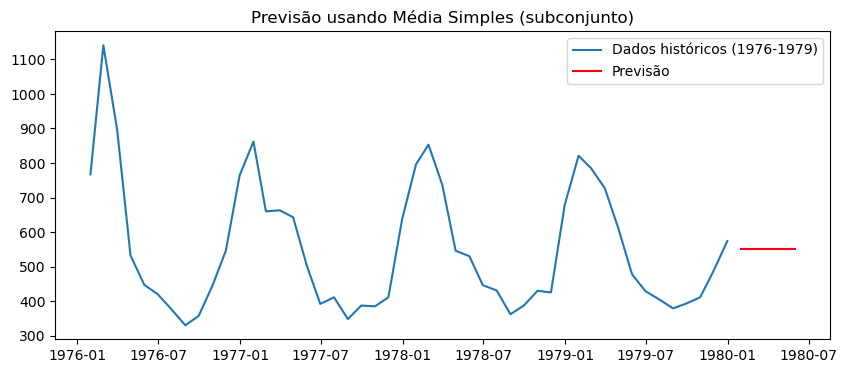

In [13]:
# Plotar previsão do subconjunto
plt.figure(figsize =(10,4))
plt.plot(fdeaths2_ts, label='Dados históricos (1976-1979)')
plt.plot(prev2, label='Previsão', color='red')
plt.title('Previsão usando Média Simples (subconjunto)')
plt.legend()
plt.show()

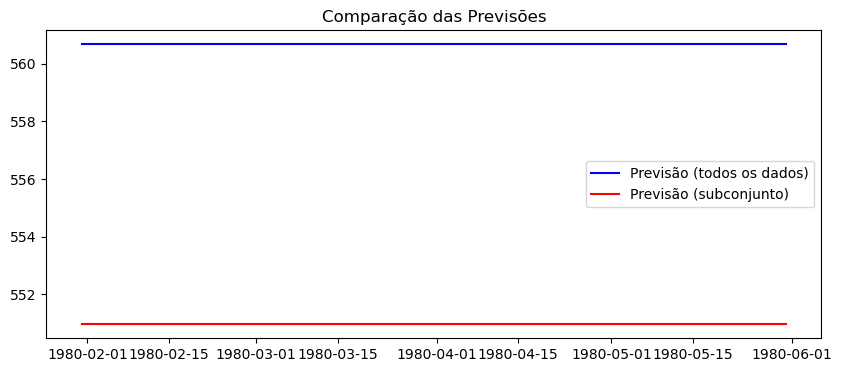

In [14]:
# Comparar as duas previsões
plt.figure(figsize =(10,4))
plt.plot(prev, label='Previsão (todos os dados)', color='blue')
plt.plot(prev2, label='Previsão (subconjunto)', color='red')
plt.title('Comparação das Previsões')
plt.legend() 
plt.show()

## Drift

In [15]:
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
import pandas as pd

In [19]:
# Carregar dados austres (população trimestral da Austrália)
austres = [    0.0, 13067.3, 13130.5, 13198.4, #1971
           13254.2, 13303.7, 13353.9, 13409.3, #1972
           13459.2, 13504.5, 13552.6, 13614.3, #1973
           13669.5, 13722.6, 13772.1, 13832.0, #1974
           13862.6, 13893.0, 13926.8, 13968.9, #1975
           14004.7, 14033.1, 14066.0, 14110.1, #1976
           14155.6, 14192.2, 14231.7, 14281.5, #1977
           14330.3, 14359.3, 14396.6, 14430.8, #1978
           14478.4, 14515.7, 14554.9, 14602.5, #1979
           14646.4, 14695.4, 14746.6, 14807.4, #1980
           14874.4, 14923.3, 14988.7, 15054.1, #1981
           15121.7, 15184.2, 15239.3, 15288.9, #1982
           15346.2, 15393.5, 15439.0, 15483.5, #1983
           15531.5, 15579.4, 15628.5, 15677.3, #1984
           15736.7, 15788.3, 15839.7, 15900.6, #1985
           15961.5, 16018.3, 16076.9, 16139.0, #1986
           16203.0, 16263.3, 16327.9, 16398.9, #1987
           16478.3, 16538.2, 16621.6, 16697.0, #1988
           16777.2, 16833.1, 16891.6, 16956.8, #1989
           17026.3, 17085.4, 17106.9, 17169.4, #1990
           17239.4, 17292.0, 17354.2, 17414.2, #1991
           17447.3, 17482.6, 17526.0, 17568.7, #1992
           17627.1, 17661.5,     0.0,     0.0] #1993

In [20]:
dates = pd.date_range(start='1971-04',
                      periods=len(austres),
                      freq='QE') # Trimestral
 
austres_ts = pd.Series(austres, index=dates)

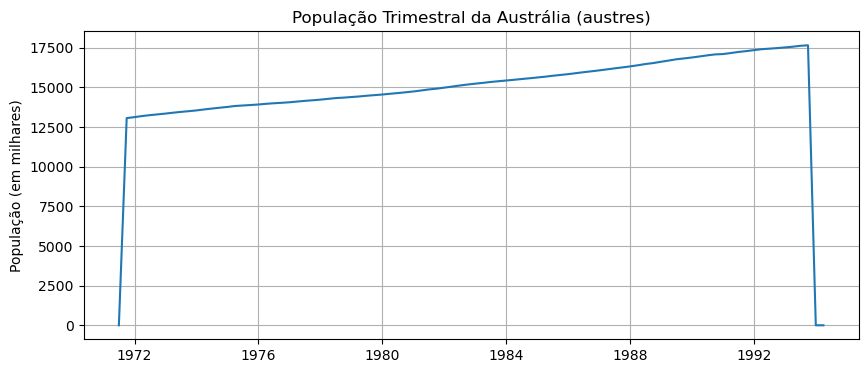

In [22]:
# Plotar série original
plt.figure(figsize=(10,4))
plt.plot(austres_ts)
plt.title('População Trimestral da Austrália (austres)')
plt.ylabel('População (em milhares)')
plt.grid(True)
plt.show()

In [23]:
# Função equivalente ao rwf (Random Walk Forecast) 

def rwf(series, h=12, drift=False):
    
    # Com drift (último valor + tendência média)
    if drift:    
        last_value = series.iloc[-1]
        mean_diff = series.diff().mean()
        forecast_values = [last_value + mean_diff * (i+1) for i in range(h)]
        
    # Sem drift (último valor constante)
    else:
        forecast_values = [series.iloc[-1]] * h
    
    forecast_index = pd.date_range(
        start   = series.index[-1] + pd. Timedelta(days=1),
        periods = h,
        freq    = series.index.inferred_freq)
    
    return pd. Series (forecast_values, index=forecast_index)

In [24]:
# Previsão sem drift (último valor constante)
prev_no_drift = rwf(austres_ts, h=12, drift=False)
print("Previsão sem drift: \n", prev_no_drift)

Previsão sem drift: 
 1994-06-30    0.0
1994-09-30    0.0
1994-12-31    0.0
1995-03-31    0.0
1995-06-30    0.0
1995-09-30    0.0
1995-12-31    0.0
1996-03-31    0.0
1996-06-30    0.0
1996-09-30    0.0
1996-12-31    0.0
1997-03-31    0.0
Freq: QE-DEC, dtype: float64


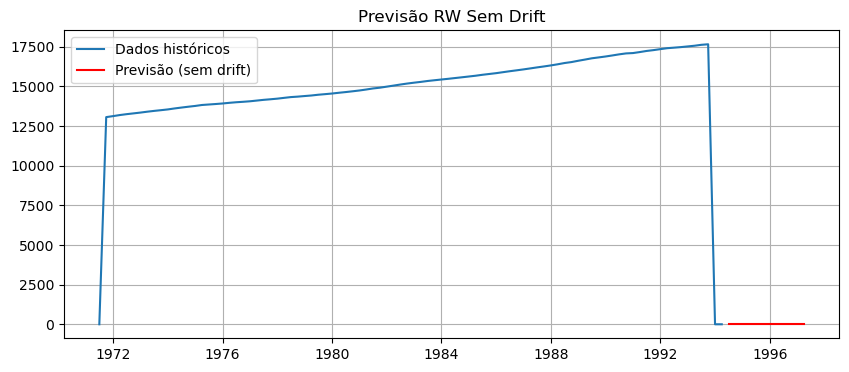

In [25]:
plt.figure(figsize =(10,4))
plt.plot(austres_ts, label='Dados históricos')
plt.plot(prev_no_drift, label='Previsão (sem drift)', color='red')
plt.title('Previsão RW Sem Drift')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# Previsão com drift (inclui tendência)
prev_with_drift = rwf(austres_ts, h=12, drift=True)
print("Previsão com drift: \n", prev_with_drift)

Previsão com drift: 
 1994-06-30    0.0
1994-09-30    0.0
1994-12-31    0.0
1995-03-31    0.0
1995-06-30    0.0
1995-09-30    0.0
1995-12-31    0.0
1996-03-31    0.0
1996-06-30    0.0
1996-09-30    0.0
1996-12-31    0.0
1997-03-31    0.0
Freq: QE-DEC, dtype: float64


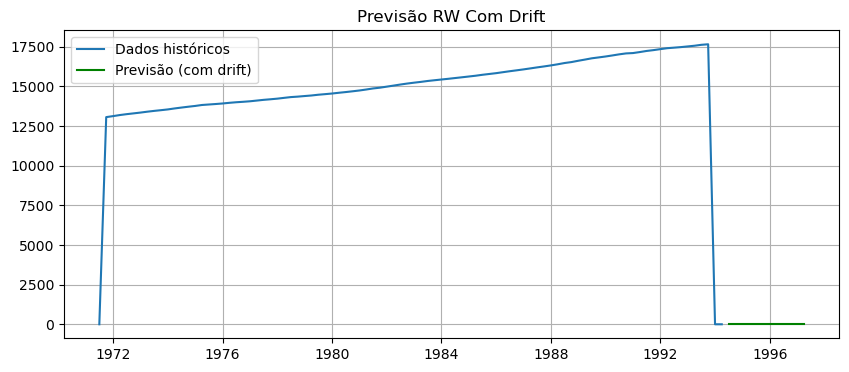

In [28]:
plt.figure(figsize =(10,4))
plt.plot(austres_ts, label='Dados históricos')
plt.plot(prev_with_drift, label='Previsão (com drift)', color='green') 
plt.title('Previsão RW Com Drift')
plt.legend()
plt.grid(True)
plt.show()